(pre-processing:dimensionality-reduction)=
# Dimensionality Reduction

As previously mentioned, scRNA-seq is a high-throughput sequencing technology that produces datasets with high dimensions in the number of cells and genes. This immediately points to the fact that scRNA-seq data suffers from the 'curse of dimensionality'. Not all genes are informative and are important for the task of cell type clustering based on their expression profiles. Therefore, an important step during preprocessing is dimensionality reduction which is used to reduce the data complexity and for visualization. Several dimensionality reduction techniques have been developed.

:::{figure-md} Dimensionality reduction

<img src="../_static/images/preprocessing_visualization/dimensionality_reduction.jpeg" alt="Dimensionality reduction" class="bg-primary mb-1" width="800px">

Dimensionality reduction typically incorporates two components: feature selection and feature extraction. Feature selects aims to identify the subset of original features that can still be used to understand the data. Feature extraction reduces the high dimensional data to lower dimensional space.

:::

Xing et al. compared in an independent comparison the stability, accuracy and computing cost of 10 different dimensionality reduction methods {cite}`Xiang2021`. They propose to use t-distributed stochastic neighbor embedding (t-SNE) as it yielded the best overall performance. Uniform manifold approximation and projection (UMAP) showed the highest stability and separates best the original cell populations. An additional dimensionality reduction worth to mention in this context is principal component analysis (PCA) which is still widely used.

Generally, t-SNE and UMAP are very robust and mostly equivalent if specific choices for the initialization are selected {cite}`Kobak2019`.

All aforementioned methods are implemented in scanpy.

In [29]:
import scanpy as sc

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [30]:
# switch to figshare afterwards
adata = sc.read("s4d8_feature_selection.h5ad")

In [32]:
adata.X = adata.layers["log1p_norm"]

We start with:

## PCA

In out dataset each cell is a vector of a `n_var`-dimensional vector space spanned by some orthonormal basis. As scRNA-seq suffers from the 'curse of dimensionality', we know that not all features are important to understand the underlying dynamics of the dataset and that there is an inherent redundancy. PCA creates a new set of uncorrelated variable, so called principle components (PCs), via an orthoginal transformation of the original dataset. The PCs are linear combinations of features in the original dataset and are ranked with decreasing order of variance to define the transformation. Through the ranking usually the first PC component amounts to the largest possible variance. PCs with the lowest variance are discarded to effictively reduce the dimensionality of the data without loosing information.

PCA offers the advantage that it his highly interpretable and computationally efficient. However, as scRNA-seq datasets are rather sparse due to dropout events and therefore highly non-linear, visualization with the linear dimensionality reduction technique PCA is not very appropriate. PCA is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.

In [33]:
# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
adata.var["highly_variable"] = adata.var["highly_deviant"]
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)

In [34]:
adata

AnnData object with n_obs × n_vars = 14814 × 20202
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'highly_variable'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'analytic_pearson_residuals', 'counts', 'log1p_norm', 'scran_normalization', 'soupX_counts'

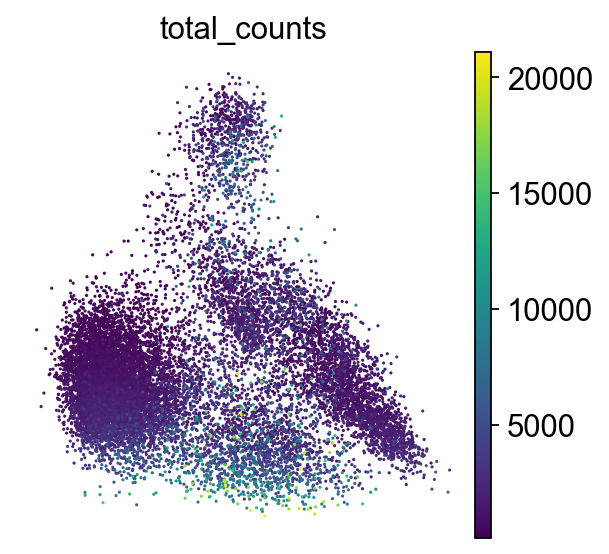

In [35]:
sc.pl.pca_scatter(adata, color="total_counts")


## t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components. The method defines a Gaussian probability distribution based on the high-dimensional Euclidean distances between data points. Subsequently, a Student t-distribution is used to recreate the probability distribution in a low dimensional space where the embeddings are optimized using gradient descent.

In [36]:
sc.tl.tsne(adata, use_rep="X_pca")

/Users/anna.schaar/opt/miniconda3/envs/preprocessing/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


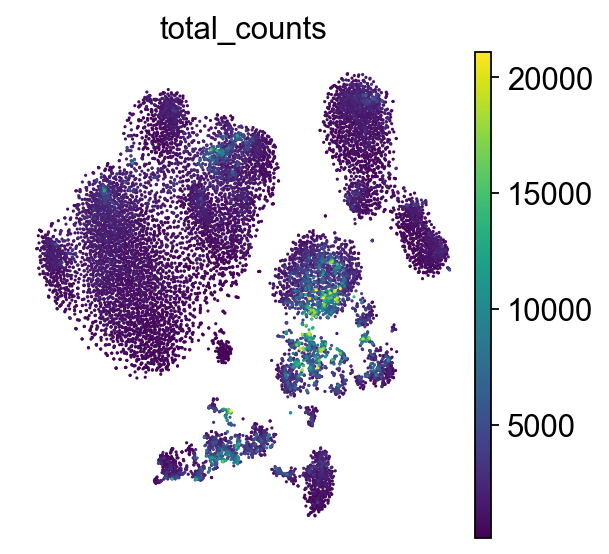

In [37]:
sc.pl.tsne(adata, color="total_counts")


## UMAP

UMAP is a graph based, non-linear dimensionality technique and principally similar to t-SNE. It constructs a high dimensional graph representation of the dataset and optimizes the low-dimensional graph representation to be structurally as similar as possible to the original graph.


We first calculate PCA and subsequently a neighborhood graph on our data.

In [38]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/Users/anna.schaar/opt/miniconda3/envs/preprocessing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


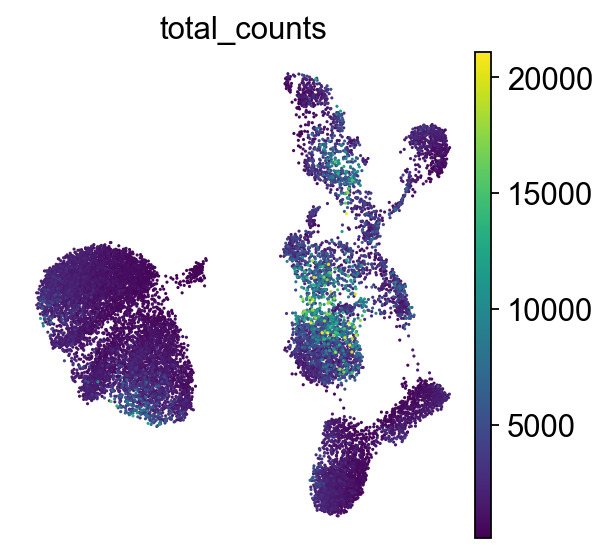

In [39]:
sc.pl.umap(adata, color="total_counts")

In [9]:
adata.write("s4d8_subset_gex_preprocessed.h5ad")

## References

```{bibliography}
:filter: docname in docnames
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Anna Schaar

### Reviewers

* Lukas Heumos
